In [1]:
# library(gtools)
# library(parallel)
# library(pbmcapply)
library(tidyverse)
library(Seurat)
library(data.table)
dotenv::load_dot_env()

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  3.0.0     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




In [4]:
srobj = readRDS(Sys.getenv("CD14srobj"))
meta = read.table(Sys.getenv("CD14metafile"), sep="\t", header=1) %>% column_to_rownames('CellID')
srobj@meta.data = meta[colnames(srobj), ]

In [7]:
srobj = srobj[, !grepl("(Doub)|(LowQual)", srobj$type)]

In [8]:
pw.de.df <- read.table(Sys.getenv("CD_PW_DIFFEXP_TSV", sep="\t", header=1)

In [6]:
pw.de.df = rbindlist(pw.de.df, idcol = "comparison_name")

In [7]:
pw.de.df %>% dim

[1] 13154674        7

In [8]:
pw.de.df = separate(pw.de.df, "comparison_name", c("ident.1", 'ident.2'), sep = "__VS__", remove = FALSE)

In [9]:
pw.de.df.filt <- pw.de.df %>%
    group_by(comparison_name) %>% 
    filter(p_val_adj < 0.01) %>% 
    top_n(50, p_val_adj)

In [10]:
pw.de.df.filt %>% dim

[1] 2149461       9

In [11]:
length(unique(pw.de.df.filt$gene))

[1] 1844

In [12]:
genes.use = as.character(unique(pw.de.df.filt$gene))
genes.use %>% head

[1] "VAMP5"  "RPL13"  "S100A4" "DNAJB1" "CST3"   "SEC61G"

In [13]:
srobj <- ScaleData(srobj, features = genes.use)

Centering and scaling data matrix



# Dendrogram

In [14]:
# calculate cluster centers
scaled.data = srobj@assays$SCT@scale.data[as.character(genes.use), ]
scaled.data.t = t(scaled.data)
scaled.data.t = as.data.frame(scaled.data.t)
scaled.data.t$cellsubsets = srobj$curatedname

agg.clst.cntrs = aggregate(scaled.data.t[, -which(colnames(scaled.data.t) == "cellsubsets")],
          list(scaled.data.t$cellsubsets), median)
colnames(agg.clst.cntrs) <- c("cellsubsets", colnames(agg.clst.cntrs)[2:length(colnames(agg.clst.cntrs))])

In [15]:
agg.clst.cntrs %>% dim

[1]  316 1845

In [16]:
agg.clst.cntrs[1:5, 1:5]

,cellsubsets,VAMP5,RPL13,S100A4,DNAJB1
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,CD.B.ACTB.JCHAIN,-0.3952281,0.4254415,-0.5584527,-0.5840271
2,CD.B.FCRL4.OSTN-AS1,-0.3952281,0.7134844,-0.5584527,-0.5840271
3,CD.B.HCK.DUSP4,-0.3952281,0.4254415,-0.5584527,-0.5840271
4,CD.B.IFI44L.IGLC2,-0.3952281,0.6235439,-0.5584527,-0.5840271
5,CD.B.IFI44L.ISG15,-0.3952281,0.6235439,-0.5584527,-0.5840271


In [17]:
any(is.na(agg.clst.cntrs))

[1] FALSE

In [18]:
clst.cntrs <- agg.clst.cntrs %>% 
    column_to_rownames("cellsubsets") %>%
    t %>% as.data.frame

In [19]:
clst.cntrs[1:5, 1:5]

,CD.B.ACTB.JCHAIN,CD.B.FCRL4.OSTN-AS1,CD.B.HCK.DUSP4,CD.B.IFI44L.IGLC2,CD.B.IFI44L.ISG15
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
VAMP5,-0.3952281,-0.3952281,-0.3952281,-0.3952281,-0.3952281
RPL13,0.4254415,0.7134844,0.4254415,0.6235439,0.6235439
S100A4,-0.5584527,-0.5584527,-0.5584527,-0.5584527,-0.5584527
DNAJB1,-0.5840271,-0.5840271,-0.5840271,-0.5840271,-0.5840271
CST3,-0.5130942,-0.5130942,-0.5130942,-0.5130942,-0.5130942


In [20]:
clst.cntrs %>%
    rownames_to_column("GeneID") %>%
    write.table(file=Sys.getenv("CD_DEND_CLUST_CNTRS_TSV"), sep="\t", row.names=F)

In [21]:
clst.cntrs %>% dim

[1] 1844  316

In [22]:
length(unique(srobj$curatedname))

[1] 316

# restore cluster centers

In [23]:
# install.packages("pvclust")
library(pvclust)

In [24]:
clst.cntrs <- read.table(file=Sys.getenv("FG_DEND_CLUST_CNTRS_TSV"), sep="\t", header=1) %>%
    column_to_rownames("GeneID")

In [25]:
result <- pvclust(clst.cntrs, method.dist="cor", method.hclust="complete", nboot=100, parallel=TRUE)

Creating a temporary cluster...done:
socket cluster with 31 nodes on host ‘localhost’
Multiscale bootstrap... Done.


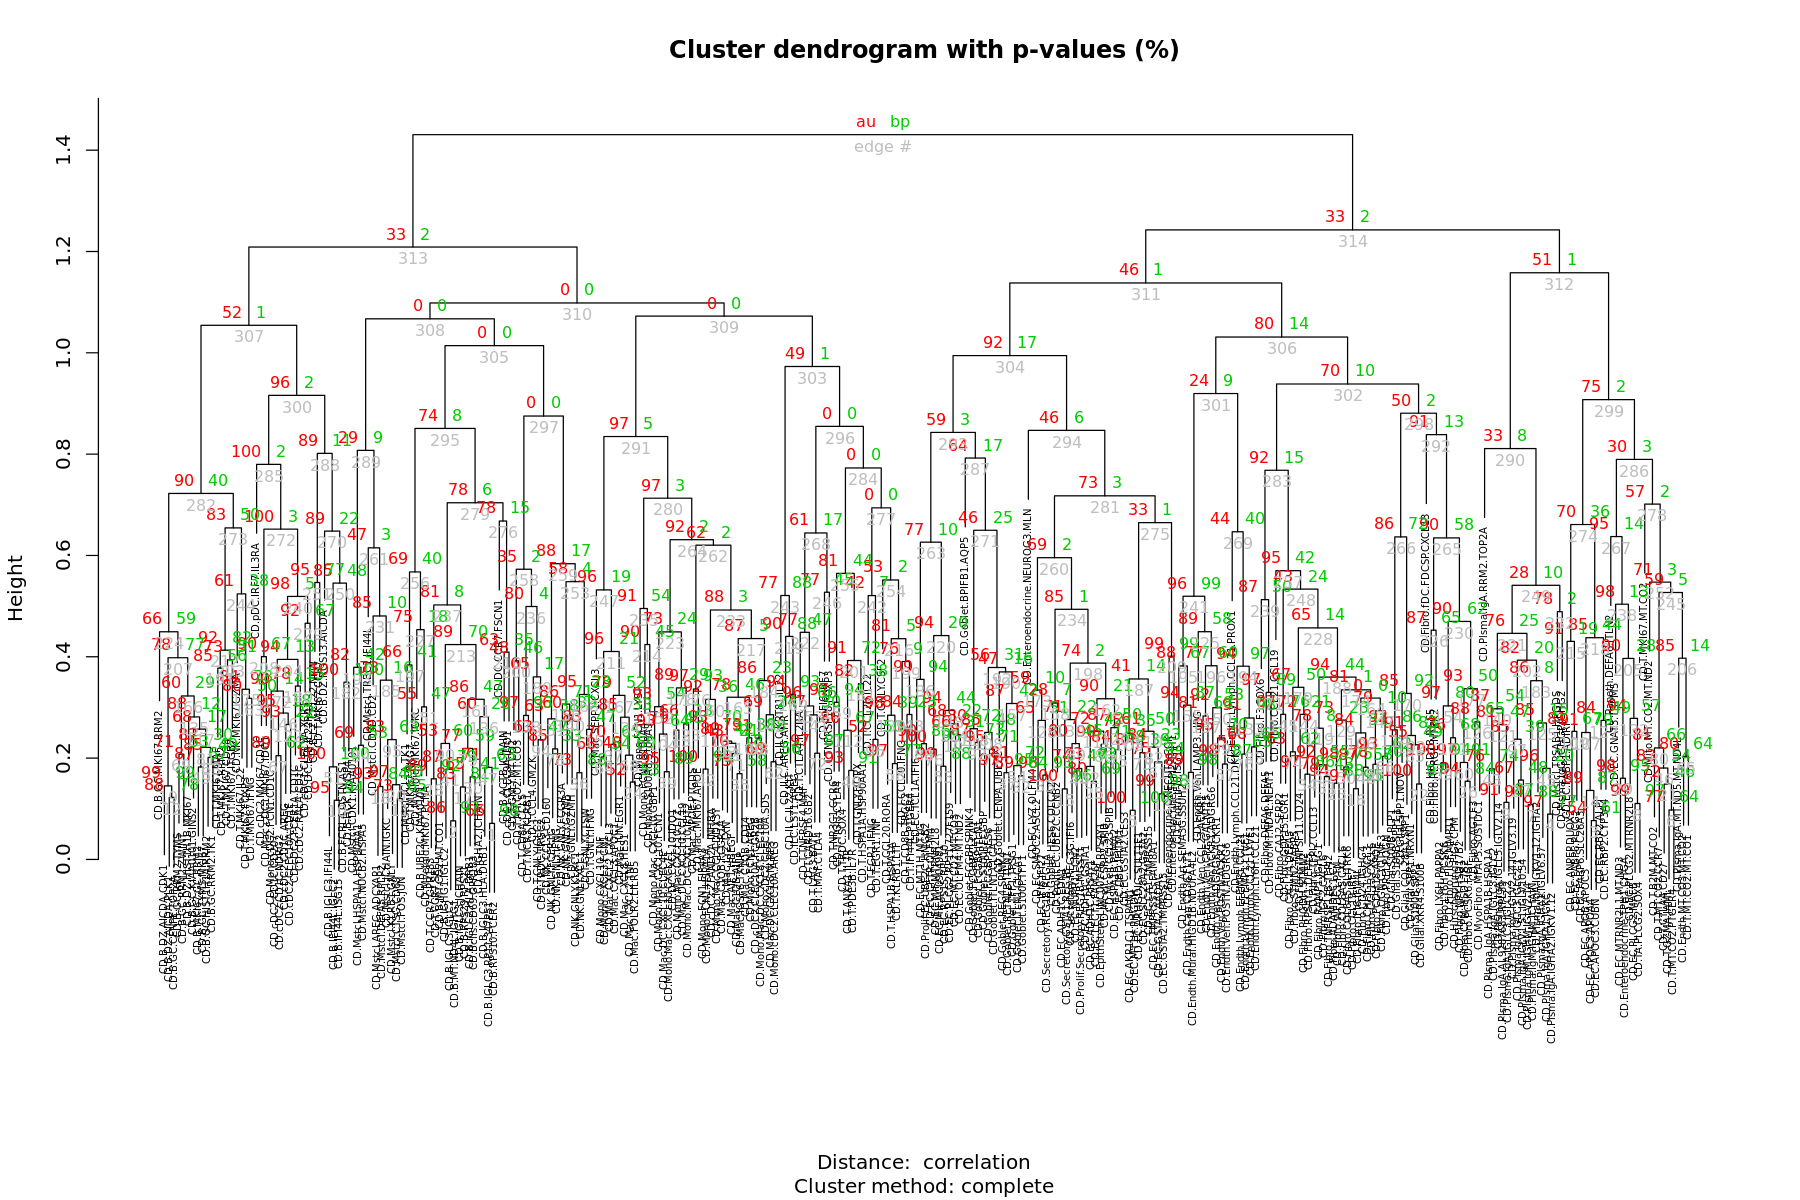

In [26]:
options(repr.plot.height = 10, repr.plot.width = 15)
plot(result, cex = .5)

In [27]:
saveRDS(result, Sys.getenv("CD_FULL_DEND_SROBJ"))

In [28]:
result = readRDS(Sys.getenv("FG_FULL_DEND_SROBJ"))

In [29]:
# options(repr.plot.height = 20, repr.plot.width = 20)
# purpleyellow <- colorRampPalette(c('purple', 'black', 'yellow'))(n=100)
# pheatmap(cor(clst.cntrs),
#          fontsize=4,
#          border_color = NA,
#          labels_row = str_replace_all(colnames(clst.cntrs), "−", "-"),
#          labels_col = str_replace_all(colnames(clst.cntrs), "−", "-"),
#          color = purpleyellow,
#          height = 20, width = 20,
#          filename = "~/plots/FGID13/clusterCenterHeatmap.pdf"
# )    

# Plot Dendro

In [30]:
# install.packages("ggdendro")
library(ggdendro)

In [31]:
table(srobj$patient)


 p011  p014  p016  p018  p019  p022  p024  p026  p027  p031  p032  p041  p042 
10176  3392  6021  7924 10524  7087  7977  9305  7391 10807  8496  6895 11035 
 p048 
 6822 

In [32]:
dd.row <- as.dendrogram(result$hclust)
ddata_x <- dendro_data(dd.row)
ddata_L <- label(ddata_x)
# ddata_L$label <- str_replace_all(ddata_L$label, "−", "-")
ddata_L$label = srobj$curatedname[match(ddata_L$label, make.names(srobj$curatedname))]
ddata_L$group <- gsub("CD\\.", "", srobj$tier1name[match(ddata_L$label, srobj$curatedname)])
ddata_L$count = as.numeric(table(factor(srobj$tierNname))[result$hclust$order])

ddata_L$diversity = srobj@meta.data %>% 
    group_by(tierNname) %>%
    summarize(diversity = 1 - sum(((table(patient)) / (length(patient)))^2)) %>%
    .[result$hclust$order, ] %>%
    .[["diversity"]]

celltype_colors = c(Epith = '#3BA63B', Fibroblast = '#D62728', Epith_Paneth = '#99C699',
                Endth = '#FF9B45', Mloid = '#8C564B', Mstcl = '#E586C8',
                Tclls = '#1ABECF', Bclls = '#1F77B4', IGA_IGL_Plsma= '#7F7F7F',
                IGA_IGK_Plsma = '#7F7F7F', IGG_Plsma = '#3F3F3F', IGM_Plsma= '#BFBFBF')

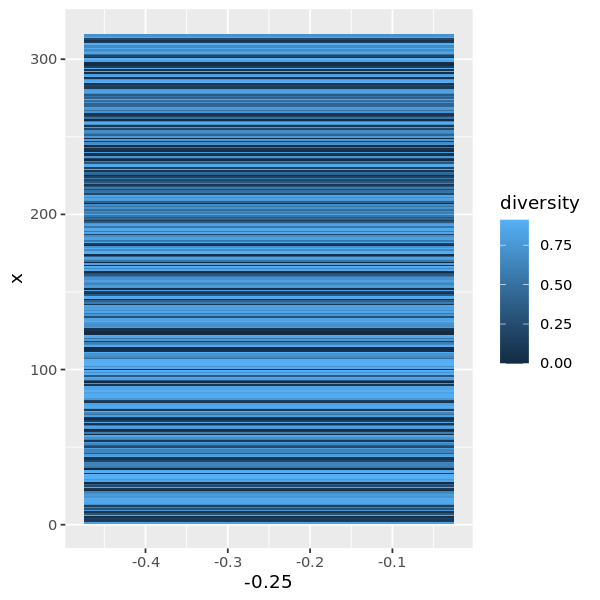

In [33]:
options(repr.plot.height = 5, repr.plot.width = 5)
ggplot(ddata_L) + geom_tile(aes(x = x, y=-0.25,fill=diversity), height=0.45) + coord_flip()

In [34]:
ddata_x$segments$y %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.07117 0.21917 0.30886 0.39093 0.50234 1.43055 

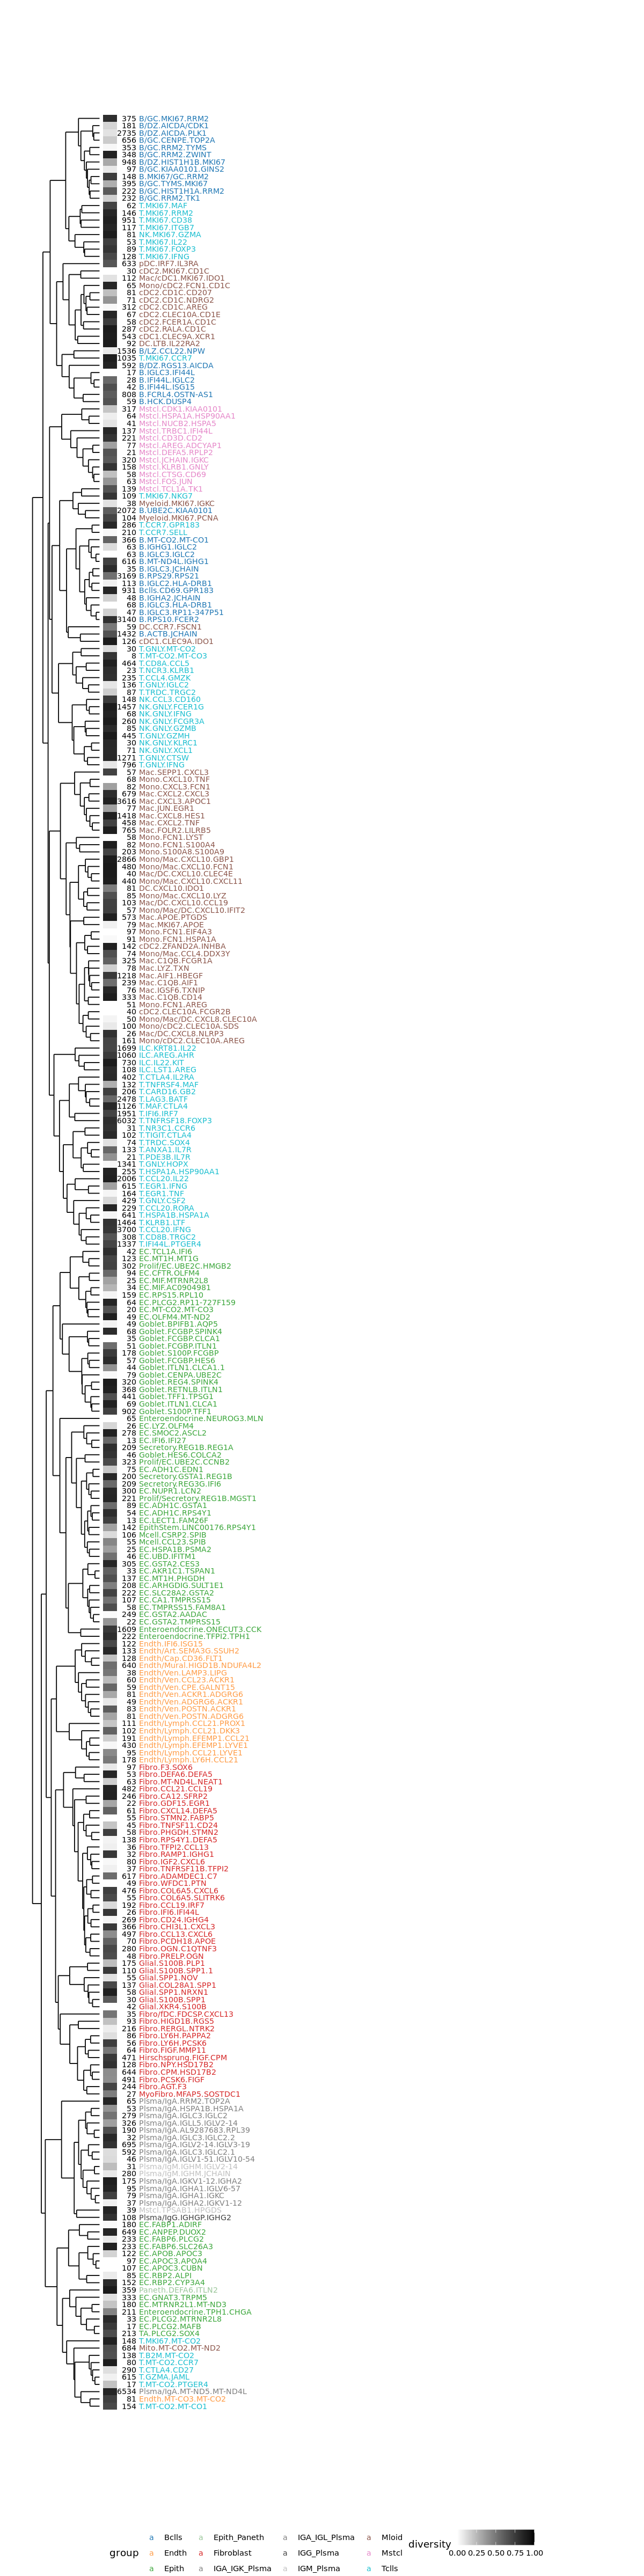

In [36]:
options(repr.plot.height = 40, repr.plot.width = 10)

y.scl = 0.5

ggplot(segment(ddata_x)) +
    geom_segment(aes(x=x, y=y*y.scl, xend=xend, yend=yend*y.scl)) + 
  
    geom_text(data=ddata_L, angle = 0, hjust = 0, size = 3,
              aes(label=substr(label,4, 100), x=x, y=-0.42, color=group)) + 
    geom_text(data=ddata_L, angle = 0, hjust = 1, size = 3,
              aes(label=count, x=x, y=-0.39),color="black") +
    geom_tile(data=ddata_L, aes(x = x, y=-0.11, fill=diversity), height=0.15) +
    scale_color_manual(values=celltype_colors) +
    scale_fill_gradient(low = "white", high = "black", limits=c(0,1)) +
    coord_flip(clip = 'off') + 
    scale_y_reverse(limits = c(1.5*y.scl, -5.5),
                   breaks = c(1, 0.75, 0.5, 0.25, 0),
                   labels = c(1, 0.75, 0.5, 0.25, 0)) +
#     scale_x_continuous(limits = c(-1,1)) +
    scale_x_reverse() +
    theme_void() + 
    theme(legend.position="bottom")

In [37]:
ggsave(filepath(Sys.getenv("FIGDIR"), "cd14atlas", "CD14_curatedname_vertical_dendrogram.pdf"),
       height = 40, width = 10, useDingbats=FALSE)